In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
from statsmodels.formula.api import ols
import statsmodels.api as sm
from bioinfokit.analys import stat

In [103]:
import technical_indicators as ti


In [104]:
df = pd.read_csv("AAPL.csv") # S&P


In [105]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-06,66.870003,67.750000,66.824997,67.677498,66.553131,106075600
1,2019-12-09,67.500000,67.699997,66.227501,66.730003,65.621384,128042400
2,2019-12-10,67.150002,67.517502,66.464996,67.120003,66.004898,90420400
3,2019-12-11,67.202499,67.775002,67.125000,67.692497,66.567886,78756800
4,2019-12-12,66.945000,68.139999,66.830002,67.864998,66.737518,137310400


In [106]:
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_the_week'] = df['Date'].dt.day_name()
df['abs_price_change_in_day'] = abs(df['Close'] - df['Open'])
df['price_change_in_day'] = df['Close'] - df['Open']

df['price_change_by_day'] = df['Close'].pct_change() # Computes the percentage change from the immediately previous row by default
df['Weekly_change'] =  df.price_change_by_day.rolling(window=5,min_periods=0).mean() 
df['diff'] =  df['Weekly_change'] - df['abs_price_change_in_day']
df['Weekly_significance_change'] =  abs(df['Weekly_change'] - df['Weekly_change'].mean())/df['Weekly_change'].std()
df = df[1:]

In [107]:
df[["price_change_by_day",'Weekly_change','diff']].head()

,price_change_by_day,Weekly_change,diff
1,-0.014000,-0.014000,-0.783997
2,0.005844,-0.004078,-0.034077
3,0.008529,0.000125,-0.489873
4,0.002548,0.000731,-0.919267
5,0.013593,0.003303,-0.919197


In [108]:
df.shape

(251, 14)

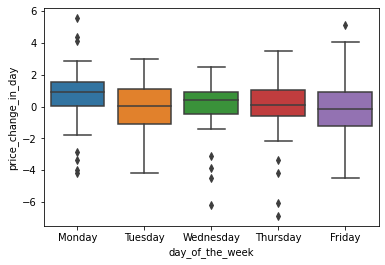

In [109]:
ax = sns.boxplot(x="day_of_the_week", y="price_change_in_day", data=df)


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


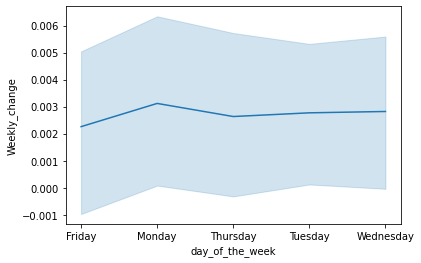

In [110]:
ax = sns.lineplot(df['day_of_the_week'], df['Weekly_change'], markers=True)



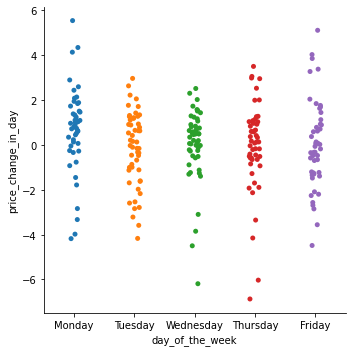

In [111]:
sns.catplot(x="day_of_the_week", y="price_change_in_day", data=df)


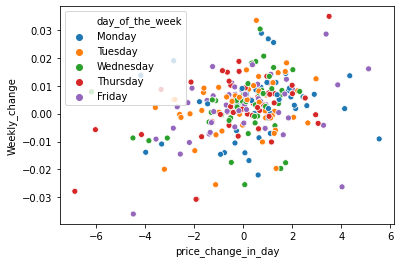

In [112]:
sns.scatterplot(x='price_change_in_day',y='Weekly_change',hue='day_of_the_week',data=df)
plt.show()

In [113]:
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):  
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return z,pval

def differenceSampZ(X,SD,n):  
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    SE = SD/sqrt(n)
    z = ((X) - 0)/SE
    pval =  norm.cdf(z)
    return round(z,4) ,pval

q = []
p = []
print("")
for week in df['day_of_the_week'].unique().tolist() :
        df1 = df.drop(df[(df['day_of_the_week'] != week)].index).copy()
        df1.iloc[1:]
        print("Z and P-score for ", week, " is  " , differenceSampZ(df1['diff'].mean(),df1['diff'].std(),2517))
        

        


Z and P-score for  Monday  is   (-60.4437, 0.0)
Z and P-score for  Tuesday  is   (-67.0868, 0.0)
Z and P-score for  Wednesday  is   (-46.9289, 0.0)
Z and P-score for  Thursday  is   (-47.3586, 0.0)
Z and P-score for  Friday  is   (-56.9874, 0.0)


In [114]:
df['diff'].mean()

-1.3573585137938093

In [115]:
df['diff'].std()

1.2425565997464718

In [116]:
n = 2517

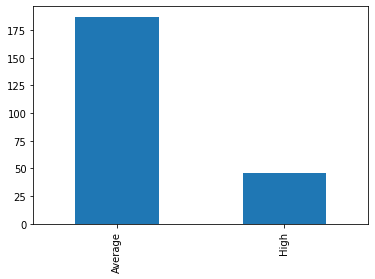

In [117]:

bins= [0,1,2]

Weekly_Change = ['Average',  'High'  ]

df['Weekly_significance_change_Range'] = pd.cut(df['Weekly_significance_change'], bins, labels=Weekly_Change)

df['Weekly_significance_change_Range'].value_counts().plot(kind='bar')

plt.savefig('fig1.png')

<AxesSubplot:xlabel='day_of_the_week', ylabel='price_change_in_day'>

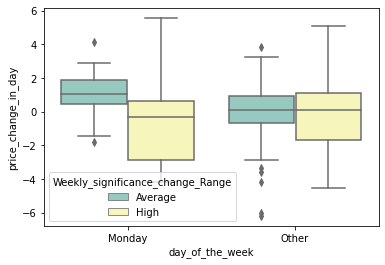

In [118]:
df = df.replace(['Tuesday', 'Wednesday', 'Friday', 'Thursday'], 'Other')

sns.boxplot(x="day_of_the_week", y="price_change_in_day", hue="Weekly_significance_change_Range", data=df, palette="Set3") 


In [119]:
model = ols('abs_price_change_in_day ~ C(day_of_the_week) + C(Weekly_significance_change_Range) + C(day_of_the_week):C(Weekly_significance_change_Range)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(day_of_the_week),3.106191,1.0,2.355117,0.126253
C(Weekly_significance_change_Range),12.258975,1.0,9.294768,0.002568
C(day_of_the_week):C(Weekly_significance_change_Range),1.147157,1.0,0.869776,0.352000
Residual,302.030700,229.0,NaN,NaN


In [120]:
res = stat()
res.tukey_hsd(df, res_var='abs_price_change_in_day', xfac_var=['day_of_the_week','Weekly_significance_change_Range'], anova_model='abs_price_change_in_day~C(day_of_the_week)+C(Weekly_significance_change_Range)+C(day_of_the_week):C(Weekly_significance_change_Range)')
res.tukey_summary

/anaconda3/lib/python3.7/site-packages/bioinfokit/analys.py:332: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(Monday, High)","(Monday, Average)",0.886508,-0.095614,1.868631,3.303818,0.092854
1,"(Monday, High)","(Other, High)",0.597785,-0.375504,1.571075,2.248031,0.387659
2,"(Monday, High)","(Other, Average)",1.075192,0.217165,1.933220,4.586527,0.007380
3,"(Monday, Average)","(Other, High)",0.288723,-0.454714,1.032159,1.421464,0.721540
4,"(Monday, Average)","(Other, Average)",0.188684,-0.395796,0.773164,1.181585,0.816521
5,"(Other, High)","(Other, Average)",0.477407,-0.092106,1.046920,3.068204,0.134779
